# Chapter 9 - Hypothesis testing
https://github.com/AllenDowney/ThinkStats2

## Reading

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np

import random

import thinkstats2
import thinkplot

Hypothesis testing:

In [3]:
class CoinTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat
    
    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

In [4]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.067

Permutation test:

In [6]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [7]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [8]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [9]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.17

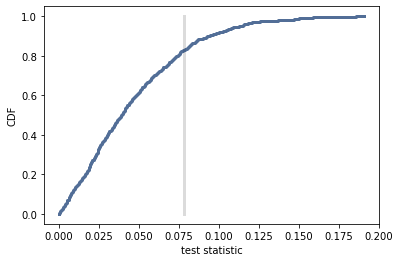

In [10]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

Under the null hypothesis, we often see differences bigger than the observed difference (17% of the time).

In [11]:
class DiffMeansOneSided(DiffMeansPermute):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

In [12]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.091

In [13]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [14]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.084

Testing correlation:

In [17]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat
    
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [18]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

In [19]:
ht.actual, ht.MaxTestStat()

(0.06883397035410911, 0.0358931430660744)

Testing proportions:

In [20]:
class DiceTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat
    
    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

In [21]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.1279

In [22]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

In [23]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.0436

In [29]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [30]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 26.71394869241753


Power:

In [32]:
def FalseNegRate(data, num_runs=1000):
    """
    Computes the chance of a false negative based on resampling.
    `data`: pair of sequences
    `num_runs`: number of experiments to simulate
    
    returns: float false negative rate
    """
    
    group1, group2 = data
    count = 0
    
    for _ in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1
            
    return count / num_runs

In [33]:
neg_rate = FalseNegRate(data)
neg_rate

0.703

# Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [46]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 23.63749505974132


In [54]:
len(live)

9148

In [57]:
def run_tests(df):
    """
    Run tests on live birth data contained in `df`.
    Returns p-values.
    """
    
    pvalues = {}
    
    # Separate first birth data from tohers
    firsts = df.loc[df['birthord'] == 1]
    others = df.loc[df['birthord'] != 1]

    # Difference in means for pregnancy length
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    pvalue = ht.PValue()
    pvalues['diff means pregnancy length'] = pvalue
    
    # One-sided difference in means for pregnancy length
    ht = DiffMeansOneSided(data)
    pvalue = ht.PValue()
    pvalues['diff means one-sided pregnancy length'] = pvalue
    
    # Chi-square tes for pregnancy length
    ht = PregLengthTest(data)
    pvalue = ht.PValue()
    pvalues['chi-square pregnancy length'] = pvalue
    
    # Difference in std dev for pregnancy length
    ht = DiffStdPermute(data)
    pvalue = ht.PValue()
    pvalues['diff stdev pregnancy length'] = pvalue
    
    # Correlation between birthweight and mother's age
    cleaned = df.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
    ht = CorrelationPermute(data)
    pvalue = ht.PValue()
    pvalues['corr birthweight and mother age'] = ht.PValue()
    
    return pvalues

In [62]:
ns = [5, 10, 50, 100, 500, 1000, 5000, len(live)]
p_values_subsets = {}
for n in ns[::-1]:
    df = thinkstats2.SampleRows(live, n)
    p_values_subsets[n] = run_tests(df)

/var/folders/pv/jsnn4l_x60x5zx013kbk8l280000gn/T/ipykernel_53248/2705733632.py:26: RuntimeWarning: invalid value encountered in true_divide
  stat = sum((observed - expected)**2 / expected)
/var/folders/pv/jsnn4l_x60x5zx013kbk8l280000gn/T/ipykernel_53248/2705733632.py:26: RuntimeWarning: invalid value encountered in true_divide
  stat = sum((observed - expected)**2 / expected)
/var/folders/pv/jsnn4l_x60x5zx013kbk8l280000gn/T/ipykernel_53248/2705733632.py:26: RuntimeWarning: invalid value encountered in true_divide
  stat = sum((observed - expected)**2 / expected)
/var/folders/pv/jsnn4l_x60x5zx013kbk8l280000gn/T/ipykernel_53248/2705733632.py:26: RuntimeWarning: invalid value encountered in true_divide
  stat = sum((observed - expected)**2 / expected)


In [63]:
p_values_subsets

{9148: {'diff means pregnancy length': 0.149,
  'diff means one-sided pregnancy length': 0.083,
  'chi-square pregnancy length': 0.0,
  'diff stdev pregnancy length': 0.094,
  'corr birthweight and mother age': 0.0},
 5000: {'diff means pregnancy length': 0.065,
  'diff means one-sided pregnancy length': 0.037,
  'chi-square pregnancy length': 0.0,
  'diff stdev pregnancy length': 0.262,
  'corr birthweight and mother age': 0.0},
 1000: {'diff means pregnancy length': 0.957,
  'diff means one-sided pregnancy length': 0.482,
  'chi-square pregnancy length': 0.009,
  'diff stdev pregnancy length': 0.378,
  'corr birthweight and mother age': 0.354},
 500: {'diff means pregnancy length': 0.523,
  'diff means one-sided pregnancy length': 0.258,
  'chi-square pregnancy length': 0.482,
  'diff stdev pregnancy length': 0.192,
  'corr birthweight and mother age': 0.029},
 100: {'diff means pregnancy length': 0.529,
  'diff means one-sided pregnancy length': 0.753,
  'chi-square pregnancy length

**Exercise:** In Section 9.3, we simulated the null hypothesis by permutation; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution. This process is called resampling. There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named `DiffMeansResample` that inherits from `DiffMeansPermute` and overrides `RunModel` to implement resampling, rather than permutation.

Use this model to test the differences in pregnancy length and birth weight. How much does the model affect the results?

In [69]:
class DiffMeansResample(DiffMeansPermute):
    
    def RunModel(self):
        pool = np.random.choice(self.pool, len(self.pool), replace=True)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [72]:
class DiffMeansResample(DiffMeansPermute):
    
    def RunModel(self):
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2

In [73]:
live, firsts, others = first.MakeFrames()

data = firsts.prglngth.values, others.prglngth.values

ht1 = DiffMeansResample(data)
pvalue1 = ht1.PValue()

ht2 = DiffMeansPermute(data)
pvalue2 = ht2.PValue()

pvalue1, pvalue2

(0.168, 0.156)

In [74]:
data = firsts.totalwgt_lb.values, others.totalwgt_lb.values

ht1 = DiffMeansResample(data)
pvalue1 = ht1.PValue()

ht2 = DiffMeansPermute(data)
pvalue2 = ht2.PValue()

pvalue1, pvalue2

(0.0, 0.0)